In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
import re

import numpy as np
import tensorflow as tf
from transformers import pipeline
import torch

from summarizer import bpe_summarize, sentencizer
from validation.validation import scicummnet_validation, rouge_metric, similarity_score, mean_rouge_fscore

In [7]:
validation_set = scicummnet_validation("../validation/data/scisummnet_release1.1__20190413/")

In [8]:
random_sample = validation_set[np.random.randint(0, len(validation_set))]
assert random_sample is not None

In [9]:
sample_text, human_summary = random_sample
human_summary

'Semantic Roles for SMT: A Hybrid Two-Pass Model\nWe present results on a novel hybrid semantic SMT model that incorporates the strengths of both semantic role labeling and phrase-based statistical machine translation.\nThe approach avoids major complexity limitations via a two-pass architecture.\nThe first pass is performed using a conventional phrase-based SMT model.\nThe second pass is performed by a re-ordering strategy guided by shallow semantic parsers that produce both semantic frame and role labels.\nEvaluation on a Wall Street Journal newswire genre test set showed the hybrid model to yield an improvement of roughly half a point in BLEU score over a strong pure phrase-based SMT baseline – to our knowledge, the first successful application of semantic role labeling to SMT.\nWe perform semantic role labeling on translation output and reordered arguments to maximize the cross-lingual match of the semantic frames between the source sentence and the target translation.\n'

In [15]:
bpe_summary = bpe_summarize(sample_text[:1024], percentile=99)
bpe_summary = re.sub(r"\n|\s{2,99}", "", bpe_summary)
bpe_summary

'Semantic Roles for SMT: A Hybrid Two-Pass ModelWe present results on a novel hybrid semantic SMT model that incorporates the strengths of both semantic role labeling and phrase-based statistical machine translation. The second pass is performed by a re-ordering strategy guided by shallow semantic parsers that produce both semantic frame and role labels. Translation errors of this type frequently r'

In [18]:
mean_rouge_fscore(bpe_summary, human_summary)

0.5023696641764561

In [19]:
similarity_score(bpe_summary, human_summary)

-0.70703125

In [20]:
bart_summarizer = pipeline("summarization")

In [21]:
maxlen = len(sample_text[:1024].split(" "))
bart_summary = bart_summarizer(sample_text[:1024], min_length=10, max_length=maxlen)
bart_summary[0]['summary_text']

'We present results on a novel hybrid semantic SMT model that incorporates the strengths of both semantic role labeling and phrase-based statistical machine translation. The approach avoids major complexity limitations via a two-pass architecture. Evaluation on a Wall Street Journal newswire genre test set showed the hybrid model to yield an improvement of roughly half a point.'

In [22]:
mean_rouge_fscore(bart_summary[0]['summary_text'], human_summary)

0.5480769190980955

In [23]:
similarity_score(bart_summary[0]['summary_text'], human_summary)

-0.67578125

In [24]:
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [25]:
sample_size = 100

In [26]:
bart_scores = []
bart_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    maxlen = len(sample_text[:1024].split(" "))
    bart_summary = bart_summarizer(sample_text[:1024], min_length=10, max_length=maxlen)
    bart_summaries.append(bart_summary)
    bart_scores.append(similarity_score(bart_summary[0]['summary_text'], human_summary))

100%|██████████| 100/100 [15:11<00:00,  9.11s/it]


In [27]:
np.mean(bart_scores)

-0.48085952

In [59]:
bpe_scores = []
bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    bpe_summaries.append(bpe_summary)
    bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 109.42it/s]


In [60]:
np.mean(bpe_scores)

-0.5605308

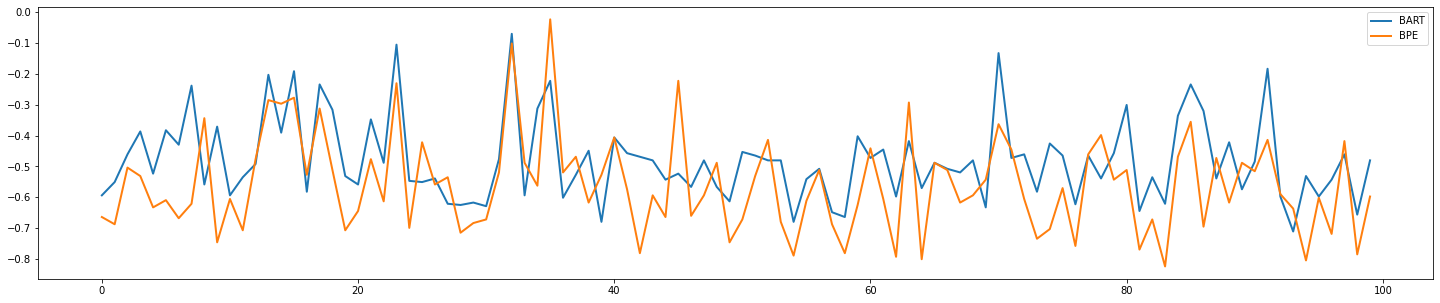

In [61]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='BART')
ax.plot(np.array(bpe_scores), linewidth=2, label='BPE')
ax.legend()

In [62]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bpe_scores)
print(best_bpe)
best = bpe_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.82421875


'Building Deep Dependency Structures Using A Wide-Coverage CCG Parser\nThis paper describes a wide-coverage statistical parser that uses Combinatory Categorial Grammar (CCG) to derive dependency structures.\nThe parser differs from most existing wide-coverage treebank parsers in capturing the long-range dependencies inherent in constructions such as coordination, extraction, raising and control, as well as the standard local predicate-argument dependencies.\nA set of dependency structures used for training and testing the parser is obtained from a treebank of CCG normal-form derivations, which have been derived (semi-) automatically from the Penn Treebank.\nThe parser correctly recovers over 80% of labelled dependencies, and around 90% of unlabelled dependencies.\nWe provide examples showing how heads can fill dependency slots during a derivation, and how long-range dependencies can be recovered through unification of co-indexed head variables.\nWe define predicate argument structure f

In [63]:
bpe_summaries[best]

'Building Deep Dependency Structures Using A Wide-Coverage CCG ParserThis paper describes a wide-coverage statistical parser that uses Combinatory Categorial Grammar (CCG) to derive dependency structures. The parser differs from most existing wide-coverage treebank parsers in capturing the long-range dependencies inherent in constructions such as coordination, extraction, raising and control, as well as the standard local predicate-argument dependencies. A set of dependency structures used for training and testing the parser is obtained from a treebank of CCG normal-form derivations, which have been derived (semi-) automatically from the Penn Treebank. The parser correctly recovers over 80% of labelled dependencies, and around 90% of unlabelled dependencies. However, the dependencies are typically derived from a context-free phrase structu'

In [34]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bart_scores)
print(best_bpe)
best = bart_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.7109375


'Interpretation As Abduction\nAn approach to abductive inference developed in the TACITUS project has resulted in a dramatic simplification of how the problem of interpreting texts is conceptualized.\nIts use in solving the local pragmatics problems of reference, compound nominals, syntactic ambiguity, and metonymy is described and illustrated.\nIt also suggests an elegant and thorough integration of syntax, semantics, and pragmatics.\n'

In [35]:
bart_summaries[best][0]["summary_text"]

'An approach to abductive inference developed in the TACITUS project has resulted in a dramatic simplification of how the problem of interpreting texts is conceptualized. Its use in solving local pragmatics problems of reference, compound nominals, syntactic ambiguity, and metonymy is described and illustrated.'

In [36]:
t,human = validation_set[:sample_size][best]
result = bpe_summarize(t[:1024], percentile=70)
re.sub(r"\n|\s{2,99}", "", result)
t

"\n  Interpretation As Abduction\n  \n    To interpret a sentence: An approach to abductive inference developed in the TAC- ITUS project has resulted in a dramatic simplification of how the problem of interpreting texts is conceptualized.\n    Its use in solving the local pragmatics problems of reference, compound nominals, syntactic ambiguity, and metonymy is described and illustrated.\n    It also suggests an elegant and thorough integration of syntax, semantics, and pragmatics.\n  \n  \n    To interpret a sentence: An approach to abductive inference developed in the TACITUS project has resulted in a dramatic simplification of how the problem of interpreting texts is conceptualized.\n    Its use in solving the local pragmatics problems of reference, compound nominals, syntactic ambiguity, and metonymy is described and illustrated.\n    It also suggests an elegant and thorough integration of syntax, semantics, and pragmatics.\n  \n  \n    Abductive inference is inference to the best e

In [48]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bpe_summarize(blob)
result

'The most meaningful part of this sentence is here.'